In [1]:
!pip install gpflow tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.9/392.9 kB 2.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# Cargar los datos de FashionMNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalizar las imágenes y aplanarlas
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

# Convertir las etiquetas a enteros de 64 bits y aplanarlas
y_train = y_train.astype(np.int64).flatten()
y_test = y_test.astype(np.int64).flatten()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


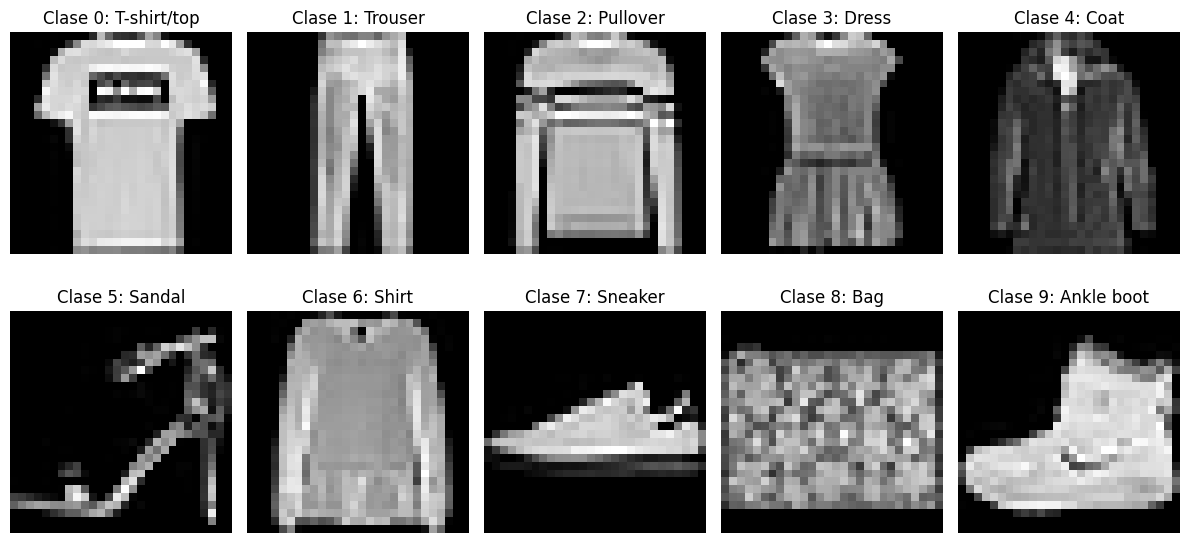

In [4]:
#Clases 
plt.figure(figsize=(12, 6))

# Etiquetas de las categorías
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index].reshape(28, 28)  # Remodelar la imagen a 28x28

    # Configurar un subgráfico para cada categoría
    plt.subplot(2, 5, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(f'Clase {i}: {categories[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Parámetros
num_classes = 10  # Número de clases en FashionMNIST
input_dim = X_train.shape[1]  # Dimensión de entrada (28*28)
num_inducing = 300  # Número de puntos de inducción
batch_size = 1000   # Tamaño de lote para el entrenamiento

In [6]:
# Definir el kernel (función de covarianza)
kernel = gpflow.kernels.SquaredExponential()

# Inicializar los puntos de inducción seleccionando aleatoriamente desde los datos de entrenamiento
inducing_variable = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]

# Definir la función de verosimilitud para clasificación multiclase
likelihood = gpflow.likelihoods.MultiClass(num_classes)


In [7]:
# Construir el modelo SVGP
model = gpflow.models.SVGP(kernel=kernel,
                           likelihood=likelihood,
                           inducing_variable=inducing_variable,
                           num_latent_gps=num_classes)


In [8]:
# Crear el dataset de entrenamiento con minibatches
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0])  # Mezclar los datos
train_dataset = train_dataset.batch(batch_size)  # Dividir en minibatches

In [9]:
# Definir el número de épocas y el optimizador
num_epochs = 100
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Inicializar una lista para almacenar las pérdidas
loss_history = []

# Función de optimización
@tf.function
def optimization_step(model, X_batch, Y_batch):    
    with tf.GradientTape() as tape:
        # Calcular la Evidencia Inferior del Logaritmo Marginal (ELBO)
        elbo = model.elbo((X_batch, Y_batch))
        loss = -elbo  # El objetivo es maximizar el ELBO, por lo que minimizamos su negativo
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
# Bucle de entrenamiento
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    for step, (X_batch, Y_batch) in enumerate(train_dataset):
        loss = optimization_step(model, X_batch, Y_batch)
        loss_value = loss.numpy()  # Convertir el tensor a un valor numérico
        loss_history.append(loss_value)  # Almacenar la pérdida
        if step % 10 == 0:
            print(f'Step {step}, Loss: {loss_value}')

Epoch 1/100
Step 0, Loss: 8194.414786268795
Step 10, Loss: 8195.66035397004
Step 20, Loss: 8192.952127969134
Step 30, Loss: 8188.559883859335
Step 40, Loss: 8173.165002903847
Step 50, Loss: 8160.830310017996
Epoch 2/100
Step 0, Loss: 8094.968826846258
Step 10, Loss: 8019.188710213889
Step 20, Loss: 7778.002055853131
Step 30, Loss: 7420.418170410241
Step 40, Loss: 7106.622871646123
Step 50, Loss: 6500.591883944358
Epoch 3/100
Step 0, Loss: 5822.196099716284
Step 10, Loss: 5322.59565990613
Step 20, Loss: 4917.773761569768
Step 30, Loss: 4489.597520146743
Step 40, Loss: 4094.920553433977
Step 50, Loss: 3698.5236414370906
Epoch 4/100
Step 0, Loss: 3633.8892203774235
Step 10, Loss: 3481.451577316639
Step 20, Loss: 3563.6205973556353
Step 30, Loss: 3241.933889506492
Step 40, Loss: 3341.9171960356766
Step 50, Loss: 3187.9749696862345
Epoch 5/100
Step 0, Loss: 3074.037940120239
Step 10, Loss: 3327.2961302640706
Step 20, Loss: 3032.850224615518
Step 30, Loss: 3128.3888250699565
Step 40, Loss: 3

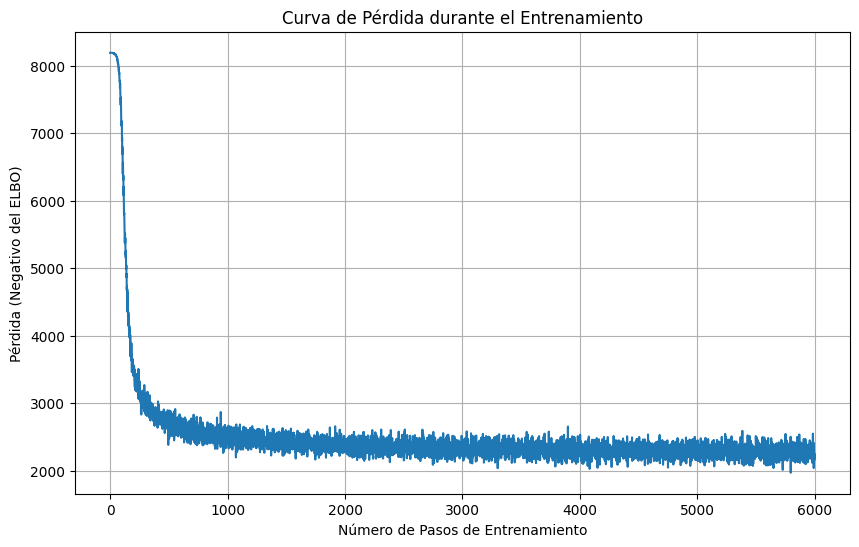

In [11]:
# Graficar la curva de pérdida
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Número de Pasos de Entrenamiento')
plt.ylabel('Pérdida (Negativo del ELBO)')
plt.grid(True)
plt.show()

In [12]:
# Paso 5: Evaluar el modelo y generar el informe de clasificación
X_test_tensor = tf.convert_to_tensor(X_test)
mean, var = model.predict_y(X_test_tensor)
predictions = np.argmax(mean, axis=1)
accuracy = np.mean(predictions.reshape(-1, 1) == y_test)
print(f'Test set accuracy: {accuracy * 100:.2f}%')

# Generar el informe de clasificación
report = classification_report(y_test, predictions, digits=4)
print("\nClassification Report:\n")
print(report)

Test set accuracy: 10.00%

Classification Report:

              precision    recall  f1-score   support

           0     0.7407    0.8570    0.7946      1000
           1     0.9905    0.9400    0.9646      1000
           2     0.7548    0.7050    0.7291      1000
           3     0.8372    0.8740    0.8552      1000
           4     0.7023    0.8140    0.7541      1000
           5     0.9412    0.8800    0.9096      1000
           6     0.6671    0.4630    0.5466      1000
           7     0.8999    0.8990    0.8994      1000
           8     0.9107    0.9590    0.9342      1000
           9     0.8866    0.9540    0.9191      1000

    accuracy                         0.8345     10000
   macro avg     0.8331    0.8345    0.8306     10000
weighted avg     0.8331    0.8345    0.8306     10000



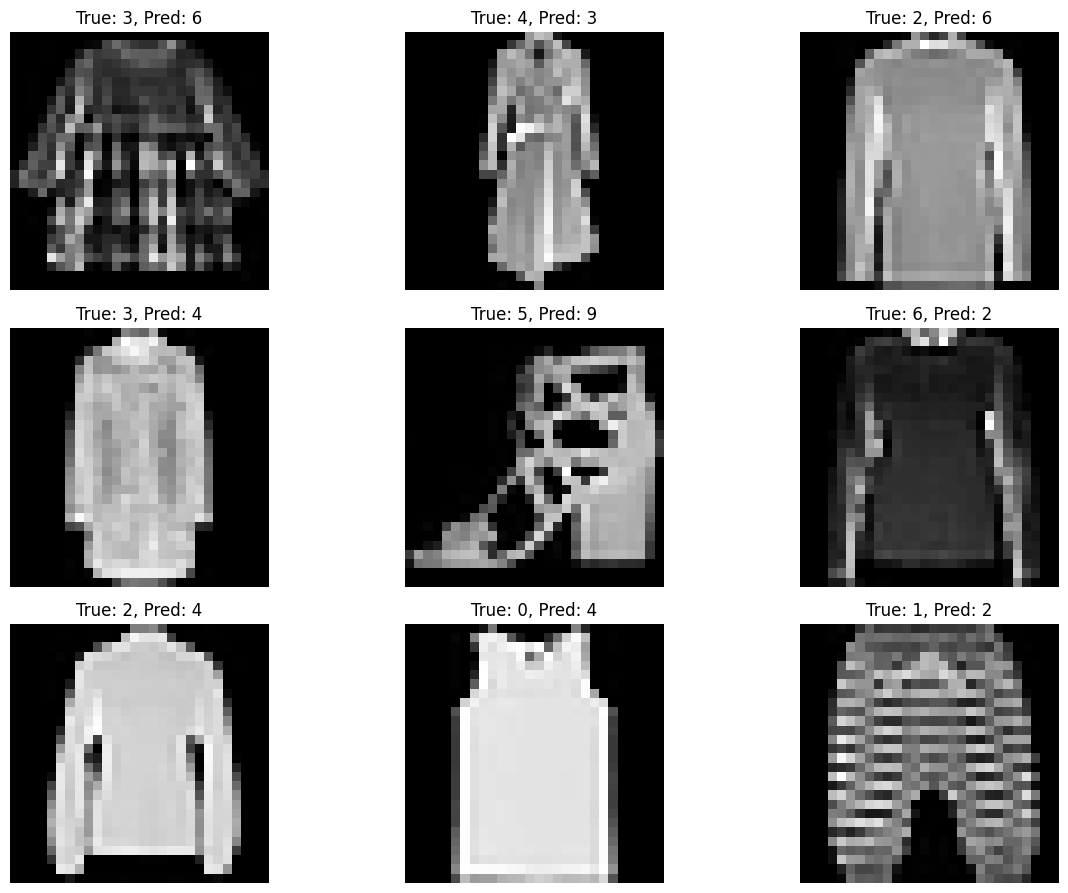

In [13]:
# Encontrar los índices de las imágenes mal clasificadas
misclassified_indices = np.where(predictions != y_test)[0]

# Seleccionar algunas imágenes mal clasificadas
num_images = 9
sample_indices = np.random.choice(misclassified_indices, num_images, replace=False)

# Graficar las imágenes mal clasificadas
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 3, i+1)
    image = X_test[idx].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {y_test[idx]}, Pred: {predictions[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

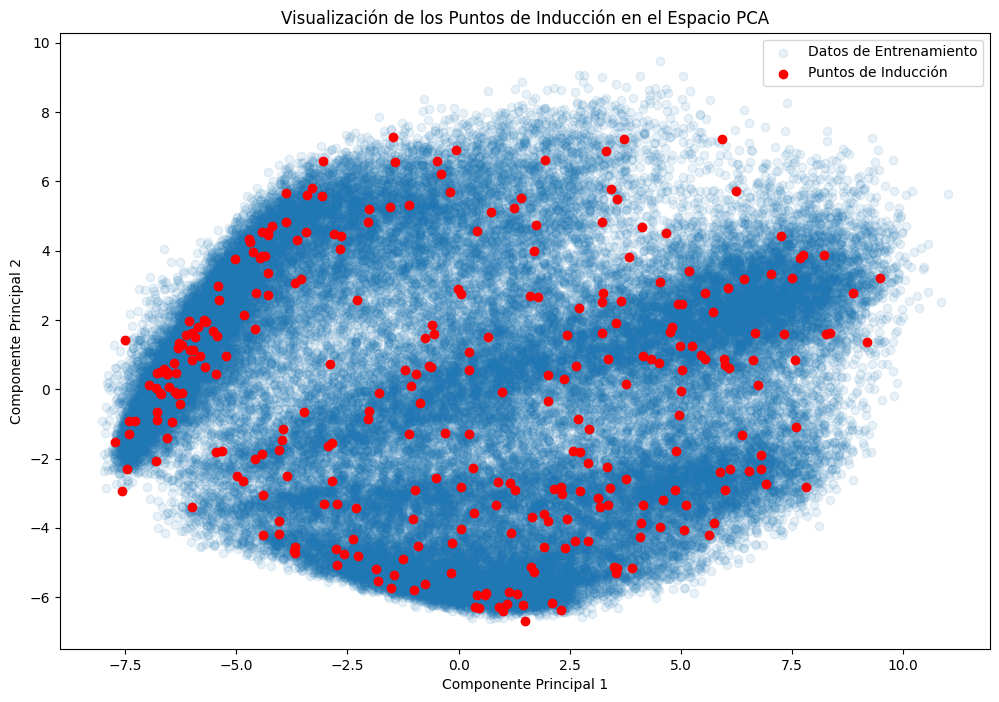

In [14]:
# Aplicar PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
inducing_variable_pca = pca.transform(inducing_variable)

# Graficar los datos de entrenamiento y los puntos de inducción
plt.figure(figsize=(12, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.1, label='Datos de Entrenamiento')
plt.scatter(inducing_variable_pca[:, 0], inducing_variable_pca[:, 1], color='red', label='Puntos de Inducción')
plt.title('Visualización de los Puntos de Inducción en el Espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()